Dense NN

In [2]:
import torch

# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 打印使用的設備
print(f"Using device: {device}")

# 如果使用 GPU，可以打印 GPU 的資訊
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))  # 打印 GPU 的名稱
    print(f"Memory Usage:")
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.1f} MB")
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1024**2:.1f} MB")

Using device: cuda
NVIDIA GeForce GTX 1060 3GB
Memory Usage:
Allocated: 0.0 MB
Cached: 0.0 MB


Epoch 1/20, Train Loss: 0.6248, Train Acc: 0.8028, Val Loss: 0.2488, Val Acc: 0.9259
Epoch 2/20, Train Loss: 0.4018, Train Acc: 0.8787, Val Loss: 0.1922, Val Acc: 0.9404
Epoch 3/20, Train Loss: 0.3598, Train Acc: 0.8917, Val Loss: 0.1774, Val Acc: 0.9471
Epoch 4/20, Train Loss: 0.3325, Train Acc: 0.9006, Val Loss: 0.1705, Val Acc: 0.9474
Epoch 5/20, Train Loss: 0.3221, Train Acc: 0.9049, Val Loss: 0.1601, Val Acc: 0.9516
Epoch 6/20, Train Loss: 0.3030, Train Acc: 0.9088, Val Loss: 0.1619, Val Acc: 0.9494
Epoch 7/20, Train Loss: 0.2968, Train Acc: 0.9102, Val Loss: 0.1483, Val Acc: 0.9559
Epoch 8/20, Train Loss: 0.2867, Train Acc: 0.9137, Val Loss: 0.1292, Val Acc: 0.9615
Epoch 9/20, Train Loss: 0.2825, Train Acc: 0.9162, Val Loss: 0.1435, Val Acc: 0.9540
Epoch 10/20, Train Loss: 0.2749, Train Acc: 0.9194, Val Loss: 0.1349, Val Acc: 0.9598
Epoch 11/20, Train Loss: 0.2675, Train Acc: 0.9206, Val Loss: 0.1267, Val Acc: 0.9611
Epoch 12/20, Train Loss: 0.2666, Train Acc: 0.9213, Val Loss: 0

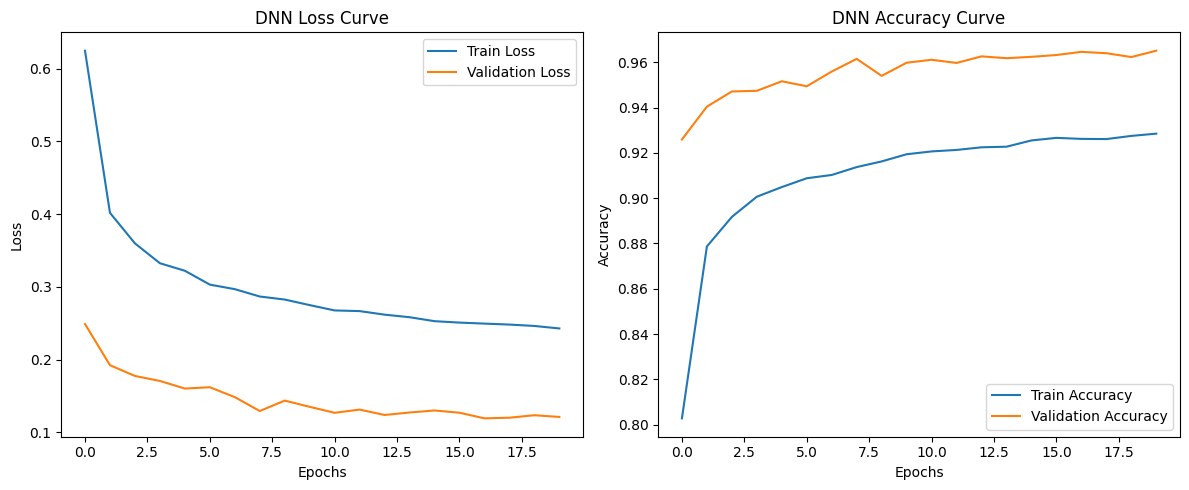

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. 加載 MNIST 數據集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 正規化到 [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 定義模型
class DenseNN(nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 3. 訓練準備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNN().to(device)  # 將模型移動到 GPU 或 CPU

criterion = nn.CrossEntropyLoss()  # CrossEntropy 包含了 softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 函數：計算損失和準確率
def evaluate(loader, model, device, criterion):
    model.eval()  # 切換到評估模式
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

# 4. 訓練模型
epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()  # 切換到訓練模式
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # 計算訓練準確率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # 計算驗證損失和準確率
    val_loss, val_acc = evaluate(test_loader, model, device, criterion)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 5. 可視化損失和準確率曲線 
plt.figure(figsize=(12, 5))

# 損失曲線
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('DNN Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 準確率曲線
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('DNN Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

CNN

Epoch 1/20, Train Loss: 1.1901, Train Acc: 0.5965, Val Loss: 0.4684, Val Acc: 0.8589
Epoch 2/20, Train Loss: 0.6256, Train Acc: 0.7916, Val Loss: 0.3331, Val Acc: 0.8986
Epoch 3/20, Train Loss: 0.4861, Train Acc: 0.8402, Val Loss: 0.2543, Val Acc: 0.9217
Epoch 4/20, Train Loss: 0.4151, Train Acc: 0.8653, Val Loss: 0.2047, Val Acc: 0.9394
Epoch 5/20, Train Loss: 0.3650, Train Acc: 0.8828, Val Loss: 0.1765, Val Acc: 0.9443
Epoch 6/20, Train Loss: 0.3233, Train Acc: 0.8981, Val Loss: 0.1582, Val Acc: 0.9519
Epoch 7/20, Train Loss: 0.3080, Train Acc: 0.9034, Val Loss: 0.1519, Val Acc: 0.9536
Epoch 8/20, Train Loss: 0.2911, Train Acc: 0.9075, Val Loss: 0.1392, Val Acc: 0.9572
Epoch 9/20, Train Loss: 0.2790, Train Acc: 0.9118, Val Loss: 0.1216, Val Acc: 0.9637
Epoch 10/20, Train Loss: 0.2675, Train Acc: 0.9169, Val Loss: 0.1186, Val Acc: 0.9636
Epoch 11/20, Train Loss: 0.2560, Train Acc: 0.9208, Val Loss: 0.1159, Val Acc: 0.9652
Epoch 12/20, Train Loss: 0.2519, Train Acc: 0.9216, Val Loss: 0

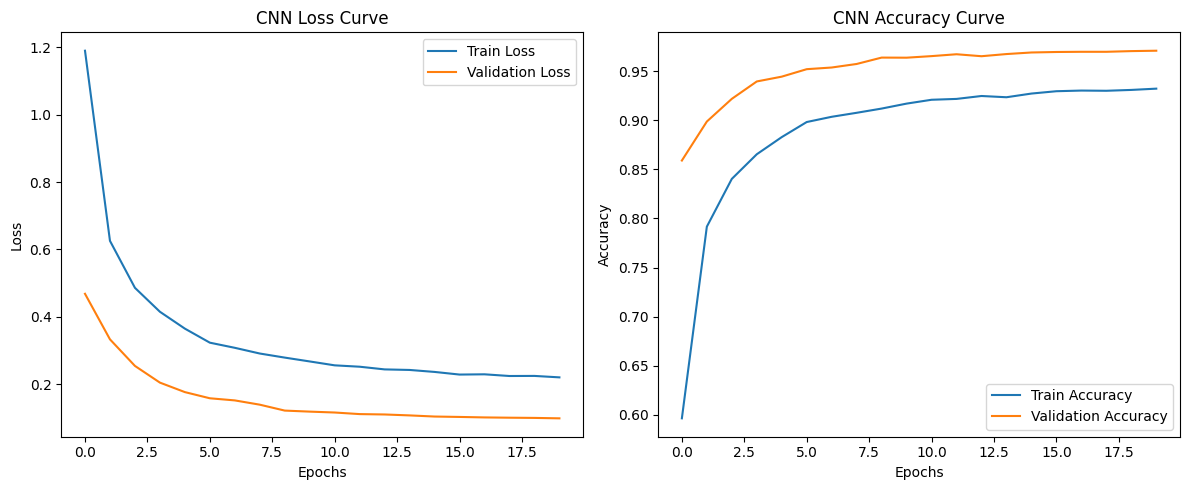

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. 數據預處理與增強
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.RandomCrop(28, padding=4),  # 隨機裁剪
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 標準化到 [-1, 1]
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 驗證集僅標準化
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. 定義 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.3)  # 調整 Dropout
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. 訓練準備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # 添加 L2 正則化
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # 動態調整學習率

# 函數：計算損失和準確率
def evaluate(loader, model, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# 4. 訓練模型
epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # 驗證集
    val_loss, val_acc = evaluate(test_loader, model, device, criterion)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    scheduler.step()  # 更新學習率
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 5. 繪圖
plt.figure(figsize=(12, 5))

# 損失曲線
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('CNN Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 準確率曲線
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('CNN Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()